In [2]:
import pandas as pd
# Define os nomes das colunas e as larguras de cada campo
colspecs = [(2, 10), (10, 22), (56, 69), (82, 95)]
names = ['Data', 'Codigo', 'Preco_Abertura', 'Preco_Fechamento']

# Carrega o arquivo
df_2022 = pd.read_fwf('COTAHIST_A2022.TXT', colspecs=colspecs, names=names, header=None)
df_2023 = pd.read_fwf('COTAHIST_A2023.TXT', colspecs=colspecs, names=names, header=None)
df_2024 = pd.read_fwf('COTAHIST_A2024.TXT', colspecs=colspecs, names=names, header=None)



In [3]:

df_2022.head(100)

,Data,Codigo,Preco_Abertura,Preco_Fechamento
0,COTAHIST,.2022BOVESPA,NaN,NaN
1,20220103,02GNDI3,5970.0,5727.0
2,20220103,02ABEV3,1542.0,1515.0
3,20220103,02MODL11,1080.0,1071.0
4,20220103,02TASA4,2500.0,2428.0
...,...,...,...,...
95,20220218,12VSLH11,949.0,948.0
96,20220218,12GCRI11,9795.0,9770.0
97,20220218,12PRSN11B,158.0,143.0
98,20220218,12ONEF11,14997.0,14997.0


In [4]:
df_2023.head()

,Data,Codigo,Preco_Abertura,Preco_Fechamento
0,COTAHIST,.2023BOVESPA,NaN,NaN
1,20230102,02NEOE3,1540.0,1498.0
2,20230102,02NEXP3,31.0,29.0
3,20230102,02NGRD3,148.0,143.0
4,20230102,02NINJ3,270.0,269.0


In [5]:
df_2024.head(10)

,Data,Codigo,Preco_Abertura,Preco_Fechamento
0,COTAHIST,.2024BOVESPA,NaN,NaN
1,20240102,02AALR3,1020.0,850.0
2,20240102,02ABCB4,2398.0,2279.0
3,20240102,02ABEV3,1372.0,1359.0
4,20240102,02BBDC3,1526.0,1498.0
5,20240102,02ALPA3,1011.0,999.0
6,20240102,02ALPA4,1010.0,931.0
7,20240102,02ALPK3,492.0,447.0
8,20240102,02ALUP11,3146.0,3025.0
9,20240102,02ALUP3,1046.0,1007.0


In [6]:
frames = [df_2022, df_2023]
df_2022e2023 = pd.concat(frames)
df_2022e2023.head()

,Data,Codigo,Preco_Abertura,Preco_Fechamento
0,COTAHIST,.2022BOVESPA,NaN,NaN
1,20220103,02GNDI3,5970.0,5727.0
2,20220103,02ABEV3,1542.0,1515.0
3,20220103,02MODL11,1080.0,1071.0
4,20220103,02TASA4,2500.0,2428.0


In [7]:
AMAZON_df = df_2022e2023[df_2022e2023['Codigo'].str.endswith('AMZO34')]

print(AMAZON_df)

             Data    Codigo  Preco_Abertura  Preco_Fechamento
152      20220103  02AMZO34         11955.0           11930.0
2541     20220119  02AMZO34         11200.0           10860.0
2565     20220221  02AMZO34          9960.0            9786.0
5904     20220204  02AMZO34         10557.0           10233.0
6807     20220104  02AMZO34         12302.0           12000.0
...           ...       ...             ...               ...
1345496  20231221  34AMZO34          3754.0            3702.0
1347177  20231222  34AMZO34          3740.0            3715.0
1349027  20231226  34AMZO34          3741.0            3689.0
1350523  20231227  34AMZO34          3708.0            3692.0
1352256  20231228  34AMZO34          3715.0            3698.0

[498 rows x 4 columns]


In [8]:
AMAZON_df['Data'] = pd.to_datetime(AMAZON_df['Data'], format='%Y%m%d')

# Extraindo ano, mês e dia
AMAZON_df['Ano'] = AMAZON_df['Data'].dt.year
AMAZON_df['Mes'] = AMAZON_df['Data'].dt.month
AMAZON_df['Dia'] = AMAZON_df['Data'].dt.day

C:\Users\srgio\AppData\Local\Temp\ipykernel_1368\4240046411.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AMAZON_df['Data'] = pd.to_datetime(AMAZON_df['Data'], format='%Y%m%d')
C:\Users\srgio\AppData\Local\Temp\ipykernel_1368\4240046411.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AMAZON_df['Ano'] = AMAZON_df['Data'].dt.year
C:\Users\srgio\AppData\Local\Temp\ipykernel_1368\4240046411.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [10]:
print(AMAZON_df)

              Data    Codigo  Preco_Abertura  Preco_Fechamento   Ano  Mes  Dia
152     2022-01-03  02AMZO34         11955.0           11930.0  2022    1    3
2541    2022-01-19  02AMZO34         11200.0           10860.0  2022    1   19
2565    2022-02-21  02AMZO34          9960.0            9786.0  2022    2   21
5904    2022-02-04  02AMZO34         10557.0           10233.0  2022    2    4
6807    2022-01-04  02AMZO34         12302.0           12000.0  2022    1    4
...            ...       ...             ...               ...   ...  ...  ...
1345496 2023-12-21  34AMZO34          3754.0            3702.0  2023   12   21
1347177 2023-12-22  34AMZO34          3740.0            3715.0  2023   12   22
1349027 2023-12-26  34AMZO34          3741.0            3689.0  2023   12   26
1350523 2023-12-27  34AMZO34          3708.0            3692.0  2023   12   27
1352256 2023-12-28  34AMZO34          3715.0            3698.0  2023   12   28

[498 rows x 7 columns]


In [13]:
AMAZON_df.isnull().sum()

Data                0
Codigo              0
Preco_Abertura      0
Preco_Fechamento    0
Ano                 0
Mes                 0
Dia                 0
dtype: int64

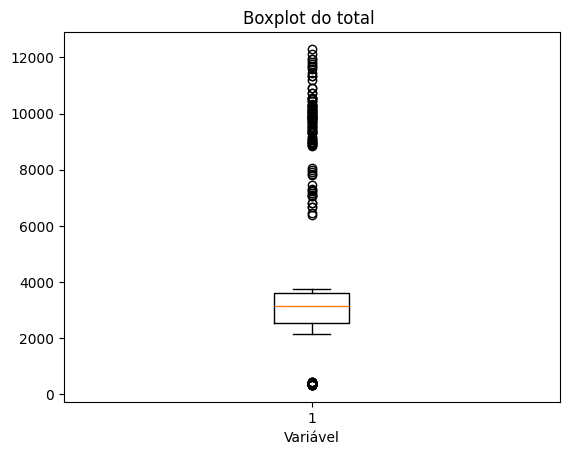

In [11]:
import matplotlib.pyplot as plt

plt.boxplot(AMAZON_df['Preco_Abertura'])
plt.title('Boxplot do total ')
plt.xlabel('Variável')
plt.show()

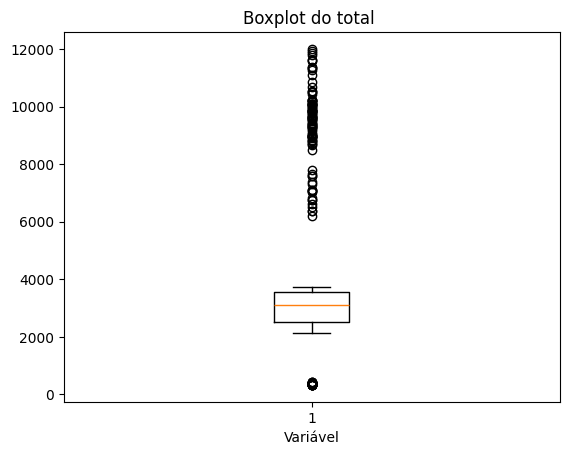

In [12]:
plt.boxplot(AMAZON_df['Preco_Fechamento'])
plt.title('Boxplot do total ')
plt.xlabel('Variável')
plt.show()